# Architectures with Mel Spectrogram as Input
## Audio Classification with the NBAC dataset

This notebook performs audio classification on audio fragments of 2 seconds long

The project starts with variables extracted from a checkpoint in 6.1 ESC50 - al5s

In [1]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import IPython.display as ipd
import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Load the NBAC data from previous checkpoint

In [2]:
reversed_labels = {0: 'dog bark', 1: 'talking', 2: 'sneezing', 3: 'traffic', 4: 'snoring', 5: 'coughing', 6: 'silence', 7: 'bed movement', 8: 'siren', 9: 'wind', 10: 'rain', 11: 'loud breathing'}
NUM_CLASSES = len(reversed_labels)

In [3]:
# Load arrays from a file
with np.load('/kaggle/input/checkpoint-2/checkpoint_2.npz') as data:
    X_train_specs = data['X_train_specs']
    X_val_specs = data['X_val_specs']
    X_test_specs = data['X_test_specs']
    y_train = data['y_train']
    y_val = data['y_val']
    y_test = data['y_test']  

## Audio splitting

Create the train test partitions of the wavs. This implementation is designed to split the audio files directly from the augmented set of spectrograms to save computational cost.

The fram rate of the spectrograms is determined by the size of the time axis. 5 second audios are sampled at 498 frames with the TensorFlow acoustic extraction.

In [4]:
def split_spectrograms(X, y, sr=(1 / (5 / X_train_specs.shape[1])), frame_duration=2, hop_duration=0.5):
    
    # Calculate number of time bins in a frame and in a hop
    frame_length = int(sr * frame_duration)
    hop_length = int(sr * hop_duration)
    
    if frame_length > X_train_specs.shape[1]:
        raise ValueError('Frame length is greater than time dimension of spectrograms')
    if hop_length > X_train_specs.shape[1]:
        raise ValueError('Hop length is greater than time dimension of spectrograms')
    
    # Number of frames and hops in each spectrogram
    n_frames_per_spectrogram = (X.shape[1] - frame_length) // hop_length + 1

    # Initialize lists to store the split spectrograms and labels
    X_split = []
    y_split = []

    # Loop over the spectrograms
    for i in range(X.shape[0]):
        # Loop over frames within the spectrogram
        for j in range(n_frames_per_spectrogram):
            start = j * hop_length
            end = start + frame_length
            # Slice the spectrogram to get the current frame
            X_split.append(X[i, start:end])
            # Append the corresponding label
            y_split.append(y[i])

    # Convert lists to arrays
    X_split = np.array(X_split)
    X_split = np.squeeze(X_split, axis=-1) # X_train_specs was processed as a TF Tensor. We convert to 2D array.
    y_split = np.array(y_split)

    return X_split, y_split

In [5]:
len(X_train_specs)

1612

In [6]:
X_train_specs, y_train = split_spectrograms(X_train_specs, y_train)

In [7]:
len(X_train_specs)

11284

In [8]:
X_val_specs, y_val = split_spectrograms(X_val_specs, y_val)

In [9]:
X_test_specs, y_test = split_spectrograms(X_test_specs, y_test)

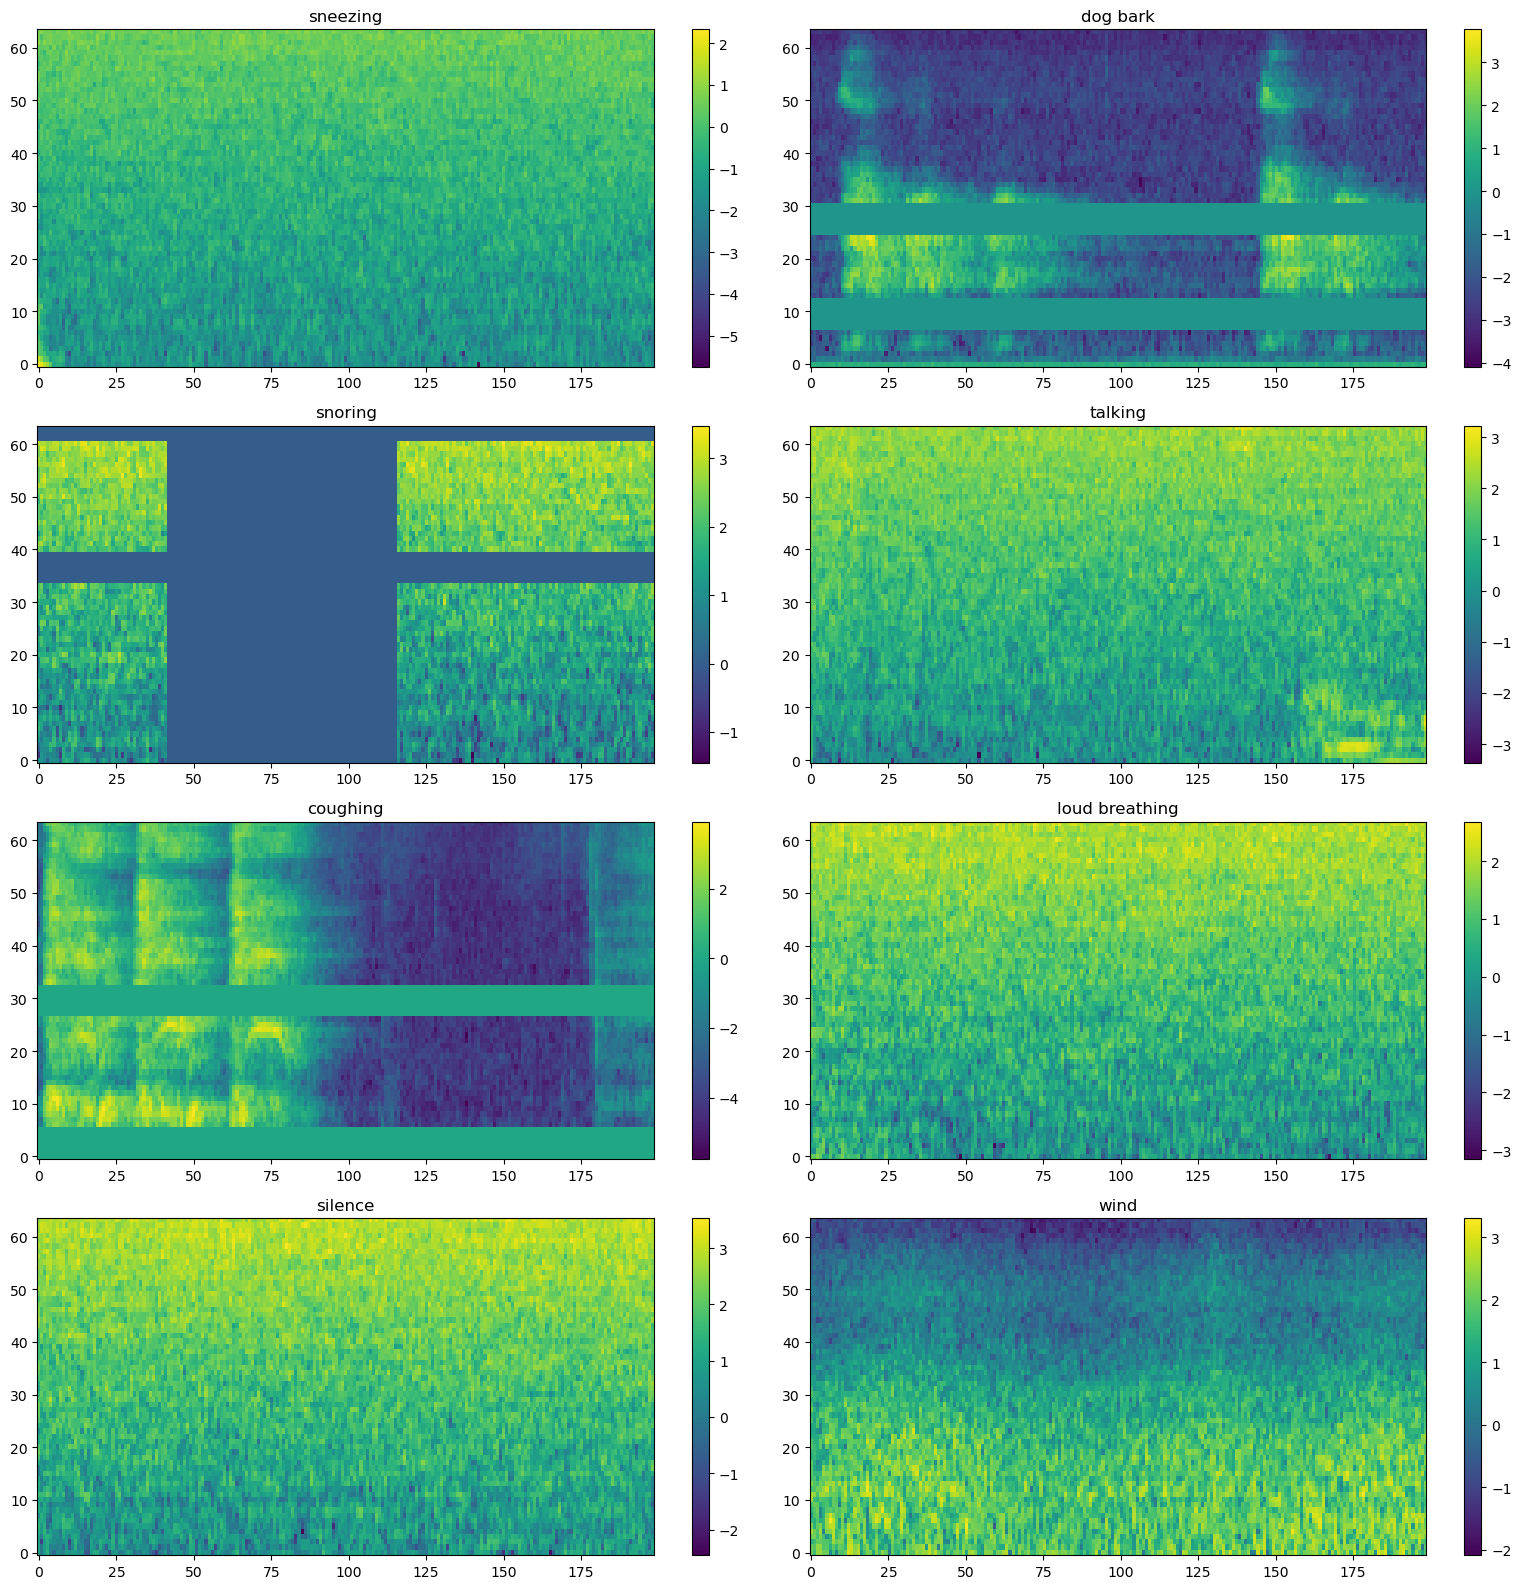

In [10]:
# View 8 random spectrograms
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,16))

# Generate 8 random indices
indices = np.random.choice(len(X_train_specs), size=8, replace=False)

for i, ax in enumerate(axs.ravel()):
    idx = indices[i]  # use the randomly generated index
    ax.set_title(reversed_labels[y_train[idx]])
    spectrogram = X_train_specs[idx].T  # Transpose the spectrogram
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

In [11]:
X_train_specs = tf.expand_dims(X_train_specs, -1)  # add a channel dimension
X_val_specs = tf.expand_dims(X_val_specs, -1)  # add a channel dimension
X_test_specs = tf.expand_dims(X_test_specs, -1)  # add a channel dimension

## Basic CNN Architecture

In [12]:
HLF = Sequential([
    tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])

Embeddings = Sequential([
    tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_specs), np.array(y_train), epochs=50, batch_size=32*4, validation_data=(np.array(X_val_specs), np.array(y_val)))

Epoch 1/50


2023-06-17 16:00:45.891784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


89/89 [==============================] - 16s 34ms/step - loss: 1.9170 - accuracy: 0.3472 - val_loss: 2.1911 - val_accuracy: 0.2532
Epoch 2/50
89/89 [==============================] - 2s 27ms/step - loss: 1.3636 - accuracy: 0.5406 - val_loss: 2.2995 - val_accuracy: 0.3890
Epoch 3/50
89/89 [==============================] - 2s 28ms/step - loss: 1.0882 - accuracy: 0.6398 - val_loss: 3.4402 - val_accuracy: 0.3083
Epoch 4/50
89/89 [==============================] - 2s 28ms/step - loss: 0.9093 - accuracy: 0.7030 - val_loss: 3.0268 - val_accuracy: 0.4017
Epoch 5/50
89/89 [==============================] - 2s 27ms/step - loss: 0.7716 - accuracy: 0.7453 - val_loss: 1.5815 - val_accuracy: 0.6563
Epoch 6/50
89/89 [==============================] - 2s 28ms/step - loss: 0.6388 - accuracy: 0.7933 - val_loss: 1.0642 - val_accuracy: 0.7228
Epoch 7/50
89/89 [==============================] - 3s 29ms/step - loss: 0.5475 - accuracy: 0.8232 - val_loss: 0.6625 - val_accuracy: 0.7963
Epoch 8/50
89/89 [=====

In [13]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_specs), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

48/48 - 0s - loss: 1.2981 - accuracy: 0.7685 - 418ms/epoch - 9ms/step
Test loss: 1.298076868057251
Test accuracy: 0.7685185074806213


In [14]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 129676


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 12, 4, 128)        93568     
                                                                 
 sequential_1 (Sequential)   (None, 256)               33024     
                                                                 
 dense (Dense)               (None, 12)                3084      
                                                                 
 activation (Activation)     (None, 12)                0         
                                                                 
Total params: 129,676
Trainable params: 129,228
Non-trainable params: 448
_________________________________________________________________


### Visualization of the training process

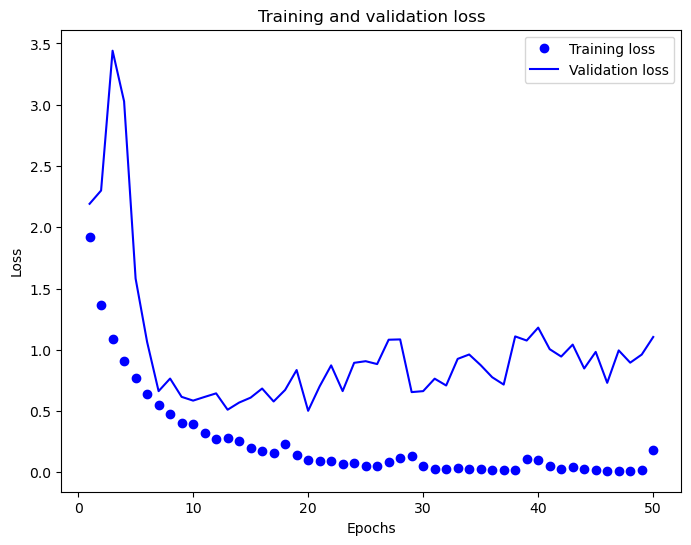

In [16]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

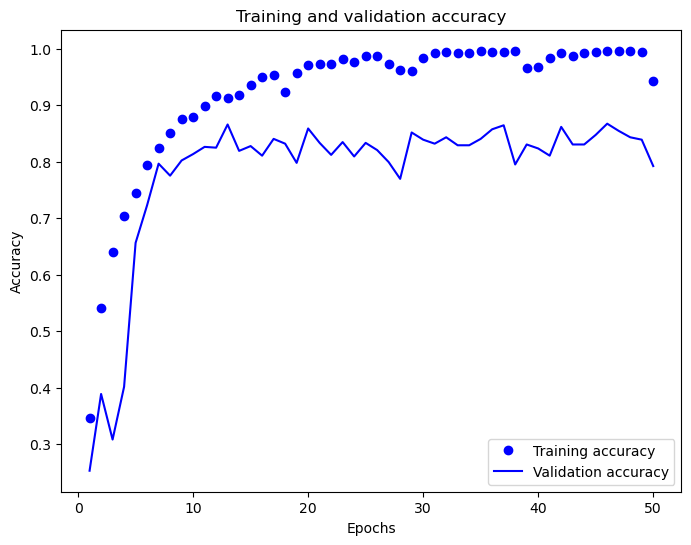

In [17]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Save and export the model

model.save('model_esc50_al2s_basic.h5')

### Confusion matrix

48/48 [==============================] - 0s 3ms/step


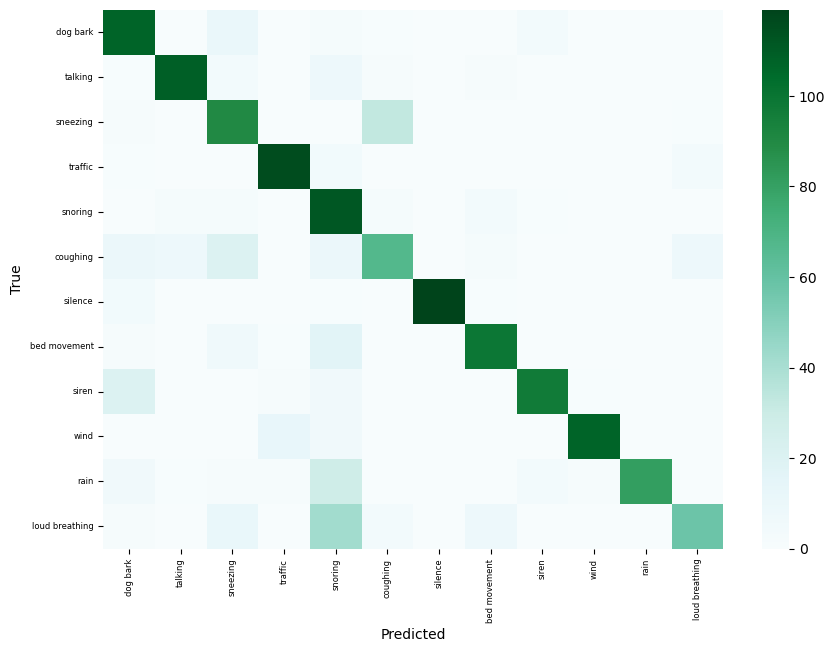

In [19]:
y_true = y_test
y_pred = model.predict(X_test_specs)
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Depth Wise Separable Convolutions

In [20]:
## Basic CNN Architecture

HLF = Sequential([
    tf.keras.layers.SeparableConv2D(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])

Embeddings = Sequential([
    tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_specs), np.array(y_train), epochs=50, batch_size=32*4, validation_data=(np.array(X_val_specs), np.array(y_val)))

Epoch 1/50


2023-06-17 16:03:13.583850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/sequential_4/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


89/89 [==============================] - 7s 34ms/step - loss: 1.9958 - accuracy: 0.3212 - val_loss: 2.4564 - val_accuracy: 0.0891
Epoch 2/50
89/89 [==============================] - 3s 29ms/step - loss: 1.5429 - accuracy: 0.4824 - val_loss: 2.3669 - val_accuracy: 0.1584
Epoch 3/50
89/89 [==============================] - 2s 28ms/step - loss: 1.3243 - accuracy: 0.5601 - val_loss: 2.1398 - val_accuracy: 0.3409
Epoch 4/50
89/89 [==============================] - 2s 27ms/step - loss: 1.1784 - accuracy: 0.6097 - val_loss: 1.6851 - val_accuracy: 0.5035
Epoch 5/50
89/89 [==============================] - 2s 28ms/step - loss: 1.0565 - accuracy: 0.6508 - val_loss: 1.1841 - val_accuracy: 0.6535
Epoch 6/50
89/89 [==============================] - 2s 28ms/step - loss: 0.9787 - accuracy: 0.6755 - val_loss: 0.8995 - val_accuracy: 0.7723
Epoch 7/50
89/89 [==============================] - 2s 27ms/step - loss: 0.9110 - accuracy: 0.6935 - val_loss: 0.7579 - val_accuracy: 0.7468
Epoch 8/50
89/89 [======

In [21]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_specs), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

48/48 - 0s - loss: 0.9867 - accuracy: 0.8142 - 377ms/epoch - 8ms/step
Test loss: 0.9866790771484375
Test accuracy: 0.8141534328460693


In [22]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 48373


In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 12, 4, 128)        12265     
                                                                 
 sequential_4 (Sequential)   (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
Total params: 48,373
Trainable params: 47,925
Non-trainable params: 448
_________________________________________________________________


### Visualization of the training process

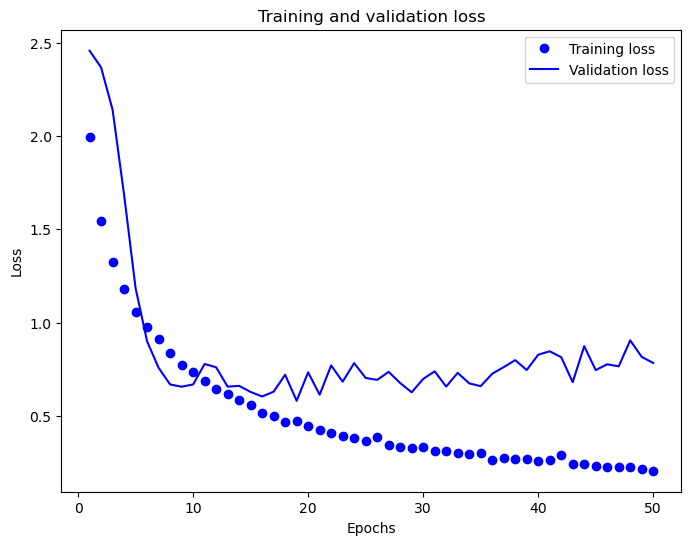

In [24]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

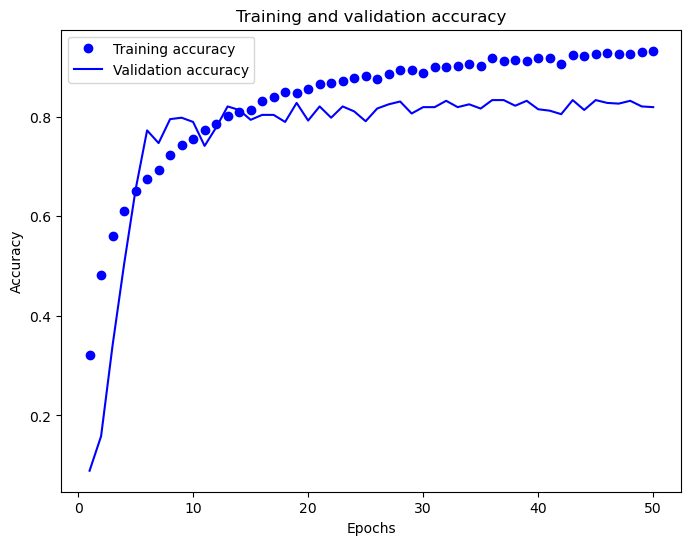

In [25]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Save and export the model

model.save('model_esc50_al2s_DW.h5')

### Confusion matrix

48/48 [==============================] - 0s 3ms/step


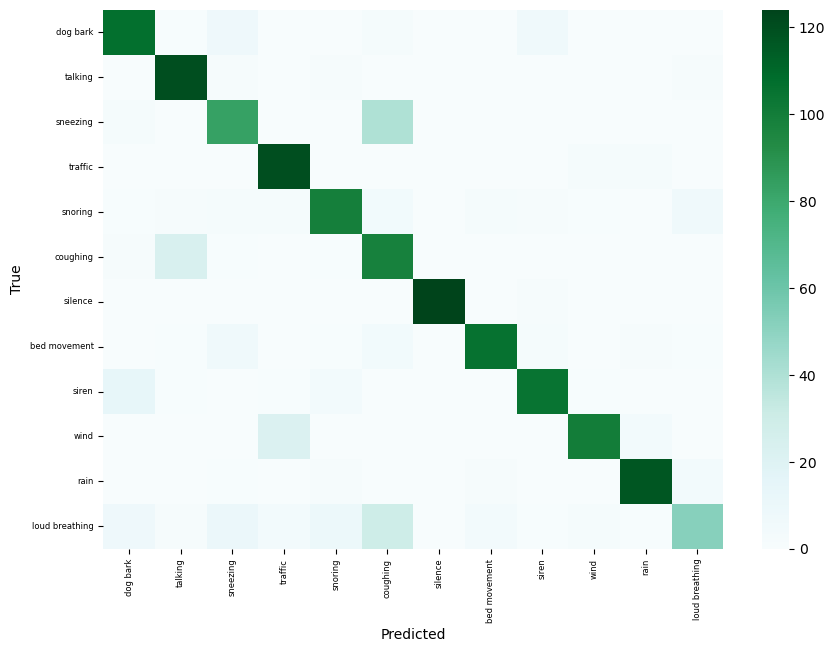

In [27]:
y_true = y_test
y_pred = model.predict(X_test_specs)
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()